# Use Pulse Detection of Optimize Filter Paramters

In [1]:
import logging
import tempfile
from urllib import request

import cupy as cp
import jess.JESS_filters as Jf
import matplotlib.pyplot as plt
import numpy as np
from jess.dispersion_cupy import dedisperse
from jess.fitters import median_fitter
from jess.JESS_filters_cupy import fft_mad, mad_spectra_flat, zero_dm, zero_dm_fft
from scipy import optimize
from scipy.stats import median_abs_deviation
from will import detect
from your import Your

logging.getLogger().setLevel(logging.INFO)

In [2]:
def show_dynamic(dynamic_spectra: np.ndarray, title: str = None, save: bool = False):
    """
    Show a dynamic spectra by first flattening it
    in frequency. Do this by getting the medians of
    each channel and then run a median filter along the
    bandpass.

    Then set the limits of the imshow so we get good detail
    for the majority of the data.

    Args:
        dynmaic_spectra - the dynamic spectra to plot

        title - Title of plot

        save - Save the plot as `title` + `.png`
    """
    spectra_mads = median_fitter(np.median(dynamic_spectra, axis=0))
    flat = dynamic_spectra - spectra_mads
    std = median_abs_deviation(flat, axis=None)
    med = np.median(flat)
    plt.figure(figsize=(20, 10))
    plt.imshow(flat.T, vmin=med - 3 * std, vmax=med + 6 * std)
    plt.xlabel("Time Sample #", size=20)
    plt.ylabel("Channel #", size=20)
    plt.colorbar()
    plt.tight_layout()
    if title is not None:
        plt.title(title, size=28)
    if save:
        plt.savefig(title + ".png", dpi=200)

## Get a chunk of dynamic spectra with a pulse

In [3]:
# a temp directory
temp_dir = tempfile.TemporaryDirectory()
B1828_fil = temp_dir.name + "/B1828.fil"
request.urlretrieve("https://zenodo.org/record/5866463/files/B1828.fil", B1828_fil)

('/tmp/tmplc1qvj4r/B1828.fil', <http.client.HTTPMessage at 0x7fb7698b5d00>)

In [4]:
yr_obj_B1828 = Your(B1828_fil)
dynamic_spectra_B1828 = yr_obj_B1828.get_data(0, 16384)

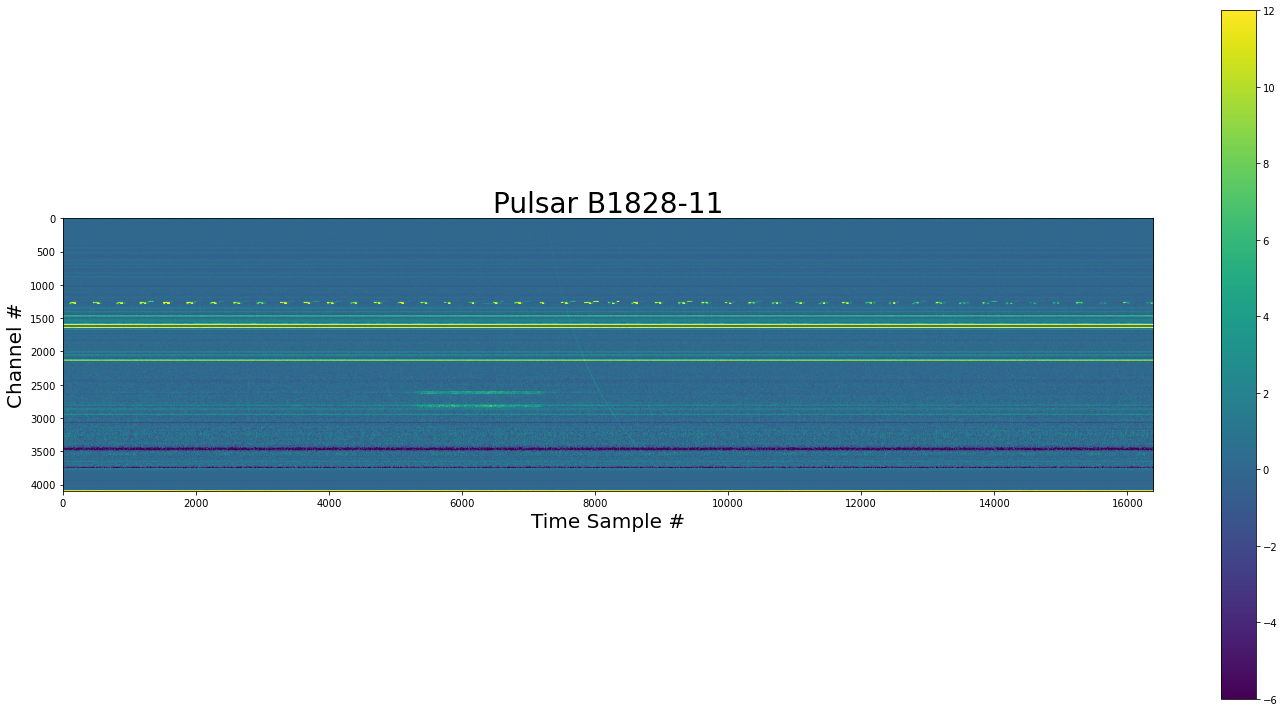

In [5]:
show_dynamic(dynamic_spectra_B1828, title="Pulsar B1828-11")

In [6]:
dynamic_spectra_B1828 = cp.asarray(
    dynamic_spectra_B1828
)  # use cupy else the filters else this will take a long time

## Define Function to optimize

In [7]:
def clean(
    x: list,
    dynamic_spectra: np.array,
    yr_obj: Your,
    dm: float,
    box_car_length: int,
    start_idx: int,
    end_idx: int,
) -> float:
    """
    Clean the data and then calculate the pulse singal to noise.

    Args:
        x - contains the paramater we will optimize over

        dynamic_spectra - Data chunk to be cleaned

        yr_object - The Your object for the data we care cleaning
                    and searching

        dm - Dismpersion Measure

        box_cat_length - Box car size of pulse in number of samples

        start_idx - Start index of the pulse search

        end_idx - End index of the pusle search

    Returns:
        Negative snr
    """
    sigma_mad = x[0]
    sigma_fft = x[1]
    modes_to_zero = int(np.around(x[2]))
    chans_per_subband = int(np.around(x[3]))
    time_median_size = int(np.around(x[4]))

    flatten_to = 64
    if modes_to_zero >= 1:
        bandpass = cp.array([flatten_to] * yr_obj.your_header.nchans)
    mad_cleaned, _, mad_per_masked = mad_spectra_flat(
        dynamic_spectra,
        chans_per_subband=chans_per_subband,
        sigma=sigma_mad,
        flatten_to=flatten_to,
        time_median_size=time_median_size,
        return_same_dtype=False,
    )
    cleaned, _, fft_per_masked = fft_mad(
        mad_cleaned,
        sigma=sigma_fft,
        chans_per_subband=chans_per_subband,
        return_same_dtype=False,
    )

    if modes_to_zero == 1:
        logging.debug("Zero DMing: Subtracting Mean")
        cleaned, zero_per_masked = zero_dm(cleaned, bandpass, return_same_dtype=False)
    elif modes_to_zero > 1:
        logging.debug("High Pass filtering: removing %i modes", modes_to_zero)
        cleaned, zero_per_masked = zero_dm_fft(
            cleaned, bandpass, modes_to_zero=modes_to_zero, return_same_dtype=False
        )
    else:
        zero_per_masked = 0

    cleaned = cleaned.get()
    time_series = detect.dedisped_time_series(
        cleaned,
        dm=dm,
        tsamp=yr_obj.your_header.tsamp,
        chan_freqs=yr_obj.chan_freqs,
    )
    pulses = detect.detect_pulses(time_series, box_car_length=box_car_length, sigma=5)
    pulse = detect.find_max_pulse(pulses, start_idx, end_idx)
    if pulse.snr is None:
        pulse.snr = 0
    logging.info(
        "mad - sig:%.2f flag:%.2f; fft - sig:%.2f flag:%.2f; modes_zero:%i flag:%.2f; chans_per_sub:%i; time_median:%i; snr:%.2f",
        sigma_mad,
        mad_per_masked,
        sigma_fft,
        fft_per_masked,
        modes_to_zero,
        zero_per_masked,
        chans_per_subband,
        time_median_size,
        pulse.snr,
    )

    return -pulse.snr

In [8]:
bounds_clean = [[3, 18], [3, 18], [0, 20], [32, 256], [0, 128]]
# sigma_mad, sigma_fft , modes_to_zeros, chans_per_subband, time_median_size

x0_clean = [9, 9, 3, 256, 7]
static_args_B1828 = (dynamic_spectra_B1828, yr_obj_B1828, 159.70, 8, 7000, 9000)

result_B1828_clean_dual_annealing = optimize.dual_annealing(
    clean,
    bounds=bounds_clean,
    x0=x0_clean,
    args=static_args_B1828,
    maxfun=500,
)

/home/jwkania/programs/miniconda3/envs/kpe/lib/python3.8/site-packages/cupy/fft/_fft.py:152: UserWarning: cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.
  cache = get_plan_cache()
INFO:root:mad - sig:9.00 flag:1.58; fft - sig:9.00 flag:0.06; modes_zero:3 flag:0.29; chans_per_sub:256; time_median:7; snr:31.69
INFO:root:mad - sig:11.67 flag:1.56; fft - sig:12.76 flag:0.03; modes_zero:17 flag:1.66; chans_per_sub:234; time_median:113; snr:29.58
INFO:root:mad - sig:3.32 flag:4.12; fft - sig:7.93 flag:0.00; modes_zero:17 flag:1.66; chans_per_sub:49; time_median:37; snr:29.61
INFO:root:mad - sig:7.18 flag:3.10; fft - sig:5.30 flag:0.16; modes_zero:14 flag:1.37; chans_per_sub:111; time_median:98; snr:31.52
INFO:root:mad - sig:16.26 flag:1.58; fft - sig:14.38 flag:0.09; modes_zero:15 flag:1.46; chans_per_sub:184; time_median:126; snr:29.67
INFO:root:mad - sig:17.70 flag:2.27; fft - sig:11.65 flag:0.13; modes_zero:7 f

In [9]:
result_B1828_evolution = optimize.differential_evolution(
    clean,
    bounds=bounds_clean,
    args=static_args_B1828,
    maxiter=200,
)

INFO:root:mad - sig:6.21 flag:3.76; fft - sig:13.91 flag:0.01; modes_zero:13 flag:1.27; chans_per_sub:129; time_median:99; snr:33.90
INFO:root:mad - sig:16.32 flag:2.51; fft - sig:3.20 flag:2.20; modes_zero:17 flag:1.66; chans_per_sub:49; time_median:18; snr:28.26
INFO:root:mad - sig:11.33 flag:2.85; fft - sig:7.67 flag:1.23; modes_zero:19 flag:1.85; chans_per_sub:34; time_median:123; snr:27.96
INFO:root:mad - sig:8.39 flag:3.26; fft - sig:6.59 flag:0.07; modes_zero:20 flag:1.95; chans_per_sub:41; time_median:56; snr:29.36
INFO:root:mad - sig:4.95 flag:2.80; fft - sig:10.10 flag:0.01; modes_zero:12 flag:1.17; chans_per_sub:238; time_median:5; snr:33.38
INFO:root:mad - sig:14.51 flag:3.33; fft - sig:10.87 flag:0.06; modes_zero:2 flag:0.20; chans_per_sub:131; time_median:61; snr:30.04
INFO:root:mad - sig:16.90 flag:2.81; fft - sig:3.57 flag:2.45; modes_zero:7 flag:0.68; chans_per_sub:52; time_median:81; snr:29.26
INFO:root:mad - sig:12.20 flag:3.35; fft - sig:17.36 flag:0.00; modes_zero:

In [10]:
print(result_B1828_clean_dual_annealing)
print(result_B1828_evolution)

     fun: -35.01661343496518
 message: ['Maximum number of function call reached during annealing']
    nfev: 500
    nhev: 0
     nit: 47
    njev: 4
  status: 0
 success: False
       x: array([  5.65155747,   5.13261988,  13.02677417, 203.69602183,
         4.46267415])
     fun: -34.93575316842094
 message: 'Optimization terminated successfully.'
    nfev: 681
     nit: 8
 success: True
       x: array([  5.43681263,   6.05909635,   2.83038914, 197.7145994 ,
        97.94509833])


## Use on a Crab pulse

In [11]:
B0531_fil = temp_dir.name + "/B0531+21.fil"
request.urlretrieve(
    "https://zenodo.org/record/5875992/files/B0531%2B21.fil?download=1", B0531_fil
)

('/tmp/tmplc1qvj4r/B0531+21.fil', <http.client.HTTPMessage at 0x7fb829cdeeb0>)

In [12]:
yr_obj_B0531 = Your(B0531_fil)
dynamic_spectra_B0531 = yr_obj_B0531.get_data(0, 16384)

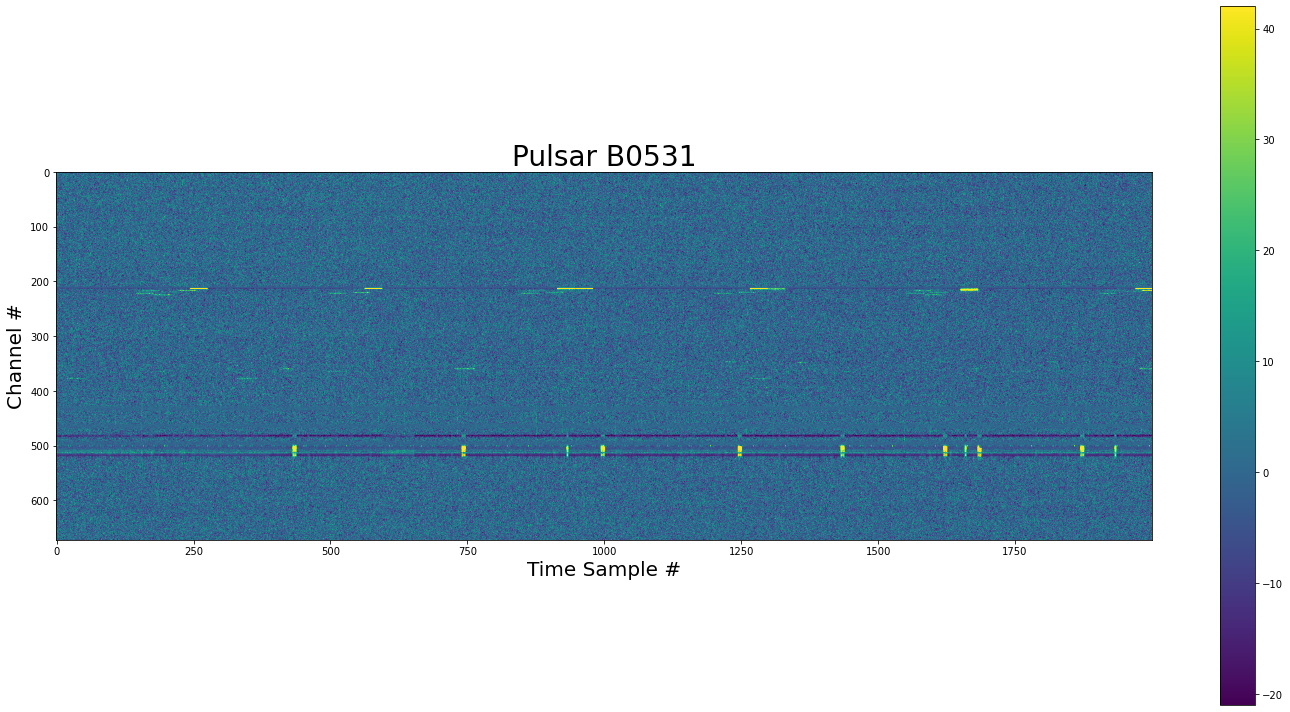

In [13]:
show_dynamic(dynamic_spectra_B0531[7000:9000], title="Pulsar B0531")

In [14]:
dynamic_spectra_B0531 = cp.asarray(dynamic_spectra_B0531)

In [16]:
static_args_B0531 = (
    dynamic_spectra_B0531,
    yr_obj_B0531,
    56.77118,
    2,
    7000,
    9000,
)

result_B0531_clean_dual_annealing = optimize.dual_annealing(
    clean,
    bounds=bounds_clean,
    x0=x0_clean,
    args=static_args_B0531,
    maxfun=500,
)

INFO:root:mad - sig:9.00 flag:0.01; fft - sig:9.00 flag:0.10; modes_zero:3 flag:1.78; chans_per_sub:256; time_median:7; snr:12.76
INFO:root:mad - sig:15.81 flag:0.00; fft - sig:14.14 flag:0.04; modes_zero:18 flag:10.68; chans_per_sub:140; time_median:115; snr:10.28
INFO:root:mad - sig:14.65 flag:0.00; fft - sig:12.98 flag:0.05; modes_zero:2 flag:1.19; chans_per_sub:145; time_median:56; snr:12.80
INFO:root:mad - sig:15.40 flag:0.00; fft - sig:13.73 flag:0.04; modes_zero:6 flag:3.56; chans_per_sub:215; time_median:94; snr:12.84
INFO:root:mad - sig:10.35 flag:0.01; fft - sig:7.76 flag:0.10; modes_zero:1 flag:0.15; chans_per_sub:98; time_median:9; snr:12.73
INFO:root:mad - sig:4.00 flag:0.33; fft - sig:17.39 flag:0.00; modes_zero:15 flag:8.90; chans_per_sub:216; time_median:62; snr:11.54
INFO:root:mad - sig:12.42 flag:0.00; fft - sig:17.39 flag:0.02; modes_zero:15 flag:8.90; chans_per_sub:216; time_median:62; snr:11.00
INFO:root:mad - sig:12.42 flag:0.00; fft - sig:11.91 flag:0.06; modes_z

In [17]:
result_B0531_evolution = optimize.differential_evolution(
    clean,
    bounds=bounds_clean,
    args=static_args_B0531,
    maxiter=200,
)

INFO:root:mad - sig:8.77 flag:0.02; fft - sig:13.82 flag:0.04; modes_zero:0 flag:0.00; chans_per_sub:139; time_median:103; snr:12.76
INFO:root:mad - sig:8.89 flag:0.02; fft - sig:11.55 flag:0.05; modes_zero:7 flag:4.15; chans_per_sub:172; time_median:114; snr:12.85
INFO:root:mad - sig:4.21 flag:0.29; fft - sig:10.25 flag:0.02; modes_zero:9 flag:5.34; chans_per_sub:191; time_median:70; snr:12.86
INFO:root:mad - sig:3.57 flag:0.48; fft - sig:5.98 flag:0.04; modes_zero:16 flag:9.50; chans_per_sub:249; time_median:33; snr:11.41
INFO:root:mad - sig:10.31 flag:0.01; fft - sig:16.55 flag:0.01; modes_zero:19 flag:11.28; chans_per_sub:65; time_median:79; snr:9.81
INFO:root:mad - sig:14.26 flag:0.00; fft - sig:4.91 flag:0.36; modes_zero:3 flag:1.78; chans_per_sub:220; time_median:14; snr:12.57
INFO:root:mad - sig:8.46 flag:0.02; fft - sig:4.61 flag:0.38; modes_zero:16 flag:9.50; chans_per_sub:230; time_median:57; snr:11.00
INFO:root:mad - sig:13.82 flag:0.00; fft - sig:5.10 flag:0.11; modes_zero

In [18]:
print(result_B0531_clean_dual_annealing)
print(result_B0531_evolution)

     fun: -13.172638988697422
 message: ['Maximum number of function call reached during annealing']
    nfev: 500
    nhev: 0
     nit: 46
    njev: 5
  status: 0
 success: False
       x: array([ 4.17497466,  4.32669105,  2.35615504, 87.42355409, 31.1747345 ])
     fun: -13.289243069922604
 message: 'Optimization terminated successfully.'
    nfev: 456
     nit: 5
 success: True
       x: array([ 4.06116867,  4.41411131,  5.09380305, 73.01270703, 62.2178845 ])
